# ViT OOD in PyTorch

## finetuning on RImgNet

In [2]:
device = 'cuda:0'

## dataset

In [3]:
import sys
sys.path.append('../')
from tqdm.auto import tqdm
from loader import get_dataloader
from augmentations import get_composed_augmentations

In [59]:
train_dl = get_dataloader({'dataset': 'RImgNet', 
                           'split':'training', 
                           'path': '../datasets', 
                           'batch_size': 64, 
                           'n_workers': 8, 
                           'shuffle':True})

Using No Augmentations
Using No Augmentations


In [120]:
train_dl_noshuffle = get_dataloader({'dataset': 'RImgNet',  'split':'training', 
                           'path': '../datasets', 'batch_size': 64, 
                           'n_workers': 8, 'shuffle':False})

Using No Augmentations
Using No Augmentations


In [91]:
rimgnet_dl = get_dataloader({'dataset': 'RImgNet', 
                           'split':'evaluation', 
                           'path': '../datasets', 
                           'batch_size': 64, 
                           'n_workers': 2, 
                           'shuffle':False})

flowers_dl = get_dataloader({'dataset': 'Flowers', 
                           'split':'evaluation', 
                           'path': '../datasets', 
                           'batch_size': 64, 
                           'n_workers': 2, 
                           'shuffle':False})

cars_dl = get_dataloader({'dataset': 'Cars', 
                           'split':'evaluation', 
                           'path': '../datasets', 
                           'batch_size': 64, 
                           'n_workers': 2, 
                           'shuffle':False})

fgvc_dl = get_dataloader({'dataset': 'FGVC', 
                           'split':'evaluation', 
                           'path': '../datasets', 
                           'batch_size': 64, 
                           'n_workers': 2, 
                           'shuffle':False})

Using No Augmentations
Using No Augmentations
Using No Augmentations
Using No Augmentations
Using No Augmentations
Using No Augmentations
Using No Augmentations
Using No Augmentations


In [74]:
xx, yy = next(iter(train_dl))

In [77]:
zz = transform(xx)

In [81]:
val_dl = get_dataloader({'dataset': 'RImgNet', 'split':'validation', 'path': '../datasets', 'batch_size': 64, 'n_workers': 2, 'shuffle':False})

Using No Augmentations
Using No Augmentations


In [11]:
transform = get_composed_augmentations({'normalize': {'mean': [0.5, 0.5, 0.5], 'std': [0.5,0.5,0.5]}})

Using normalize aug with params {'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5]}


In [12]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=9)
                                                  # id2label=id2label,
                                                  # label2id=label2id)
model.to(device);

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from torch.optim import SGD

opt = SGD(model.parameters(), lr=0.00001, momentum=0.8)

In [20]:
import os

import torch
import numpy as np

from ipywidgets import Output
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [ ]:
out = Output()
display(out)
n_epoch = 50
model.train()
l_loss = []
for i_epoch in tqdm(range(40, n_epoch)):
    for i_iter, (xx, yy) in enumerate(tqdm(train_dl)):
        model.train()
        opt.zero_grad()
        pred_ = model(pixel_values=transform(xx).to(device), labels=yy.to(device))
        l_loss.append(pred_.loss.item())
        pred_.loss.backward()
        opt.step()
        
        if i_iter % 100 == 0:
            with out:
                plt.plot(l_loss)
                out.clear_output(wait=True)
                plt.show()
    
    result_dir = f'finetune-rimgnet/epoch-{i_epoch}'
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)
    torch.save(model.state_dict(), os.path.join(result_dir, 'pytorch_model.bin'))
    
    l_pred = []
    model.eval()
    for i_iter, (xx, yy) in enumerate(tqdm(val_dl)):
        with torch.no_grad():
            pred_ = model(pixel_values=transform(xx).to(device))
            predictions = torch.argmax(pred_.logits.detach().cpu(), dim=1)
            l_pred.append(predictions)
    pred = torch.cat(l_pred)
    acc = (pred == torch.tensor(val_dl.dataset.targets)).float().mean()
    print(f'[epoch {i_epoch}] {acc}')
    with open(os.path.join(result_dir, 'acc.txt'), 'w') as f:
        f.write(str(acc.item()))
    # break

Output()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4028 [00:00<?, ?it/s]

In [82]:
l_pred = []
model.eval()
for i_iter, (xx, yy) in enumerate(tqdm(val_dl)):
    with torch.no_grad():
        pred_ = model(pixel_values=transform(xx).to(device))
        predictions = torch.argmax(pred_.logits.detach().cpu(), dim=1)
        l_pred.append(predictions)
pred = torch.cat(l_pred)
acc = (pred == torch.tensor(val_dl.dataset.targets)).float().mean()
print(f'[epoch {i_epoch}] {acc}')

  0%|          | 0/159 [00:00<?, ?it/s]

[epoch 9] 0.866305410861969


In [38]:
l_pred = []
with torch.no_grad():
    out = model(pixel_values=transform(xx).to(device))
    predictions = torch.argmax(out.logits.detach().cpu(), axis=1)
    l_pred.append(predictions)
pred = torch.cat(l_pred[-2:])
acc = (pred == torch.tensor(val_dl.dataset.targets)).float().mean()

RuntimeError: The size of tensor a (64) must match the size of tensor b (10150) at non-singleton dimension 0

## Classification output

In [16]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 10000
  Batch size = 16
/opt/conda/envs/evg/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


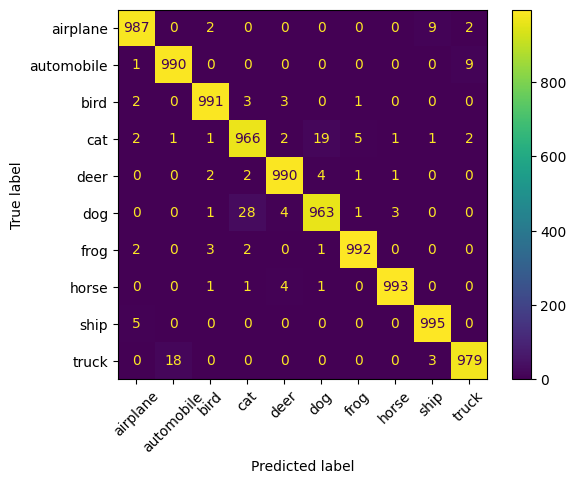

In [17]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

# Evaluate

In [92]:
from tqdm.notebook import tqdm

In [102]:
def get_logit(model, dl):
    global device
    l_pred = []
    for xx, _ in tqdm(dl):
        with torch.no_grad():
            # pred = model(xx['pixel_values'].cuda(), output_hidden_states=False)
            pred = model(xx.to(device), output_hidden_states=False)
            # pred.logits
            # pred.hidden_states
        l_pred.append(pred.logits.detach().cpu())
    return torch.cat(l_pred)

def get_prelogit(model, dl):
    global device
    l_pred = []
    for xx, _ in tqdm(dl):
        with torch.no_grad():
            # out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
            out = model(xx.to(device), output_hidden_states=True)
            out = out.hidden_states[-1][:,0,:]
            out = model.vit.layernorm(out)
        l_pred.append(out.detach().cpu())
    return torch.cat(l_pred)

In [103]:
rimgnet_pred = get_logit(model, rimgnet_dl)
flowers_pred = get_logit(model, flowers_dl)
cars_pred = get_logit(model, cars_dl)
fgvc_pred = get_logit(model, fgvc_dl)

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

In [104]:
from torch.nn.functional import softmax

In [105]:
rimgnet_msp = torch.max(softmax(rimgnet_pred, dim=1),dim=1).values
flowers_msp = torch.max(softmax(flowers_pred, dim=1),dim=1).values
cars_msp = torch.max(softmax(cars_pred, dim=1),dim=1).values
fgvc_msp = torch.max(softmax(fgvc_pred, dim=1),dim=1).values

In [107]:
import sys
sys.path.append('../')
from utils import roc_btw_arr

In [109]:
roc_btw_arr(rimgnet_msp, flowers_msp)

0.9927610480938468

In [110]:
roc_btw_arr(rimgnet_msp, cars_msp)

0.9979484207476095

In [111]:
roc_btw_arr(rimgnet_msp, fgvc_msp)

0.9938351372083021

### Mahalanobis distance

In [121]:
prelogit = get_prelogit(model, train_dl_noshuffle)

  0%|          | 0/4028 [00:00<?, ?it/s]

In [144]:
torch.save(prelogit, 'finetune-rimgnet/epoch-49/prelogit.pkl')

In [122]:
len(prelogit)

257748

In [123]:
len(train_label)

257748

In [124]:
train_label = torch.tensor(train_dl.dataset.targets)

In [125]:
'''mahalanobis statistics computation'''
l_mean = []
l_outer = []
for k in range(9):
    subset_x = prelogit[train_label == k]
    subset_mean = torch.mean(subset_x, dim=0, keepdim=True)
    # subset_outer = torch.cov(subset_x - subset_mean, correction=0) * len(subset_x)
    v = subset_x - subset_mean
    subset_outer = v.T.mm(v)
    l_mean.append(subset_mean)
    l_outer.append(subset_outer)
pooled_cov = torch.sum(torch.stack(l_outer), dim=0) / len(prelogit)
all_means = torch.stack(l_mean, dim=-1)
invcov = torch.linalg.inv(pooled_cov)

In [136]:
'''relative mahalanobis statistics'''
whole_mean = torch.mean(prelogit, dim=0, keepdim=True)
v = prelogit - whole_mean
whole_cov = v.T.mm(v) / len(prelogit)
whole_invcov = torch.linalg.inv(whole_cov)

In [143]:
'''save'''
torch.save({'all_means': all_means,
            'invcov': invcov,
            'whole_mean': whole_mean,
            'whole_invcov': whole_invcov}, 'finetune-rimgnet/epoch-49/maha-statistic.pkl')

In [128]:
def forward_maha(xx, mean, invcov):
    """
    mean: [1, D, K]
    invcov: [D, D]
    """
    z = xx.unsqueeze(-1) - mean
    op1 = torch.einsum('ijk,jl->ilk', z, invcov)
    op2 = torch.einsum('ijk,ijk->ik', op1, z)  # [B, K]
    
    return torch.min(op2, dim=1).values
    
def forward_maha_dl(model, dataloader, mean, invcov):
    global device
    l_score = []
    for xx,_ in tqdm(dataloader):
        
        out = model(xx.to(device), output_hidden_states=True)
        out = out.hidden_states[-1][:,0,:]
        out = model.vit.layernorm(out)
        
        prelogit = out.detach().cpu()
        score = forward_maha(prelogit, mean, invcov)
        l_score.append(score)
    return torch.cat(l_score)
# forward_maha(subset_x, all_means, invcov)

rimgnet_maha = forward_maha_dl(model, rimgnet_dl, all_means.double(), invcov.double())
flowers_maha = forward_maha_dl(model, flowers_dl, all_means.double(), invcov.double())
fgvc_maha = forward_maha_dl(model, fgvc_dl, all_means.double(), invcov.double())
cars_maha = forward_maha_dl(model, cars_dl, all_means.double(), invcov.double())

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [130]:
roc_btw_arr(flowers_maha, rimgnet_maha)

0.9971309844926526

In [131]:
roc_btw_arr(fgvc_maha, rimgnet_maha)

0.9999043451143145

In [129]:
roc_btw_arr(cars_maha, rimgnet_maha)

0.9998689475061002

In [199]:
cifar100_maha.min()

tensor(363.5558)

In [133]:
def forward_rel_maha_dl(model, dataloader, mean, invcov, whole_mean, whole_invcov):
    global device
    l_score = []
    for xx, _ in tqdm(dataloader):
        
        out = model(xx.to(device), output_hidden_states=True)
        out = out.hidden_states[-1][:,0,:]
        out = model.vit.layernorm(out)
        
        prelogit = out.detach().cpu()
        maha = forward_maha(prelogit, mean, invcov)
        rel_maha = forward_maha(prelogit, whole_mean, whole_invcov)
        l_score.append(maha - rel_maha)
    return torch.cat(l_score)

In [138]:
rimgnet_rel_maha = forward_rel_maha_dl(model, rimgnet_dl, all_means.double(), invcov.double(), whole_mean.unsqueeze(-1).double(), whole_invcov.double())
flowers_rel_maha = forward_rel_maha_dl(model, flowers_dl, all_means.double(), invcov.double(), whole_mean.unsqueeze(-1).double(), whole_invcov.double())
fgvc_rel_maha = forward_rel_maha_dl(model, fgvc_dl, all_means.double(), invcov.double(), whole_mean.unsqueeze(-1).double(), whole_invcov.double())
cars_rel_maha = forward_rel_maha_dl(model, cars_dl, all_means.double(), invcov.double(), whole_mean.unsqueeze(-1).double(), whole_invcov.double())

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [139]:
roc_btw_arr(flowers_rel_maha, rimgnet_rel_maha)

0.9805747259957363

In [140]:
roc_btw_arr(fgvc_rel_maha, rimgnet_rel_maha)

0.9955143888773114

In [141]:
roc_btw_arr(cars_rel_maha, rimgnet_rel_maha)

0.9962279769383878